In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [12]:
# ----------------------------
# 1) Hoop detection → centroid
# ----------------------------
def hoop_centroid_px(img_bgr, *,
                     radius_range_px=None,   # e.g., (minR, maxR) in pixels, optional
                     hough_dp=1.2,           # inverse ratio of accumulator resolution
                     hough_param1=120,       # Canny high threshold used inside Hough
                     hough_param2=30,        # accumulator threshold (smaller = more detections)
                     debug=False):
    """
    Returns (u, v) pixel centroid of the hoop or None if not found.
    Primary: contour-based circularity scoring.
    Fallback: Hough Circle Transform (cv2.HoughCircles).

    Args:
      radius_range_px: optional (minR, maxR) in pixels to constrain Hough.
      hough_dp, hough_param1, hough_param2: standard Hough tuning knobs.
      debug: if True, returns (u, v, {"method": "...", "extra": ...})
    """

    img = img_bgr.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Light contrast normalization helps thin edges / low contrast hoops
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray_eq = clahe.apply(gray)

    # Slight denoise (Gaussian/Bilateral). Bilateral preserves edges better.
    gray_blur = cv2.bilateralFilter(gray_eq, d=7, sigmaColor=50, sigmaSpace=7)

    # ---- Contour path (primary) ----
    try:
        g = cv2.GaussianBlur(gray_blur, (5,5), 0)
        v = np.median(g)
        low = int(max(0, 0.66*v))
        high = int(min(255, 1.33*v))
        edges = cv2.Canny(g, low, high)

        # Close small gaps in the ring
        edges = cv2.dilate(edges, np.ones((3,3), np.uint8), iterations=1)
        edges = cv2.erode(edges,  np.ones((3,3), np.uint8), iterations=1)

        cnts, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        best, best_score = None, -1.0
        for c in cnts or []:
            area = cv2.contourArea(c)
            if area < 200:  # tune for your image scale
                continue
            peri = cv2.arcLength(c, True)
            if peri == 0:
                continue
            circularity = 4*np.pi*area/(peri*peri)  # 1 for perfect circle
            # prefer round + sufficiently large
            score = circularity * np.sqrt(max(area, 1.0))
            if score > best_score:
                best, best_score = c, score

        if best is not None:
            M = cv2.moments(best)
            if M["m00"] != 0:
                u = M["m10"]/M["m00"]
                v = M["m01"]/M["m00"]
                return (float(u), float(v)) if not debug else (float(u), float(v), {"method":"contour","score":best_score})
    except Exception:
        # If anything goes wrong, just fall through to Hough
        pass

    # ---- Hough fallback ----
    H, W = gray.shape
    minDist = max(20, min(H, W) // 8)  # keep circles sufficiently apart
    if radius_range_px is not None:
        minR, maxR = radius_range_px
        minR = int(max(0, minR))
        maxR = int(max(minR+1, maxR))
    else:
        # Heuristic radius bounds based on image size
        # (thin hoop typically spans ~6–40% of min dimension)
        minR = int(0.03 * min(H, W))
        maxR = int(0.30 * min(H, W))

    circles = cv2.HoughCircles(
        gray_blur,
        cv2.HOUGH_GRADIENT,
        dp=hough_dp,
        minDist=minDist,
        param1=hough_param1,
        param2=hough_param2,
        minRadius=minR,
        maxRadius=maxR
    )

    if circles is not None and len(circles) > 0:
        # Choose the most confident circle (highest accumulator)
        # cv2 returns shape (1, N, 3) with (x, y, r). Accumulator not returned,
        # so we can optionally refine by edge support.
        circles = np.round(circles[0, :]).astype(int)

        # Optional: pick the circle with strongest edge support
        g2 = cv2.GaussianBlur(gray_blur, (5,5), 0)
        v2 = np.median(g2)
        low2 = int(max(0, 0.66*v2))
        high2 = int(min(255, 1.33*v2))
        e2 = cv2.Canny(g2, low2, high2)

        def edge_support(x, y, r):
            # sample points on the circumference and count edge hits
            theta = np.linspace(0, 2*np.pi, 180, endpoint=False)
            xs = np.clip((x + r*np.cos(theta)).astype(int), 0, W-1)
            ys = np.clip((y + r*np.sin(theta)).astype(int), 0, H-1)
            return int(np.count_nonzero(e2[ys, xs]))

        best_c, best_support = None, -1
        for (x, y, r) in circles:
            supp = edge_support(x, y, r)
            if supp > best_support:
                best_support = supp
                best_c = (x, y, r)

        if best_c is not None:
            x, y, r = best_c
            return (float(x), float(y)) if not debug else (float(x), float(y), {"method":"hough","radius":int(r),"edge_support":int(best_support)})

    # Nothing worked
    return None if not debug else (None, {"method":"none"})

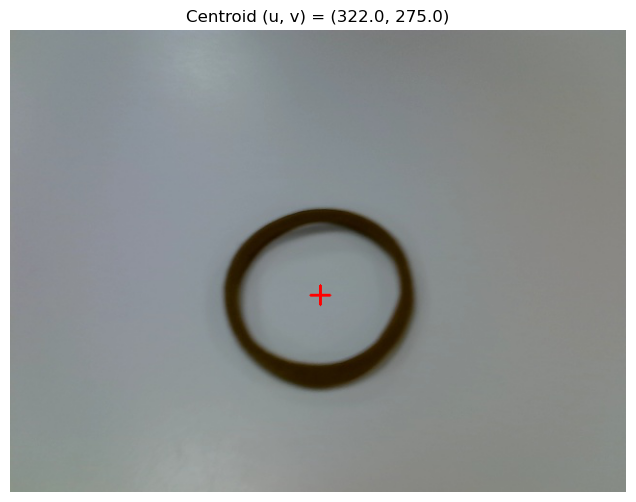

In [16]:
# Use a *raw string* for Windows paths so backslashes aren't treated as escapes
IMAGE_PATH = r"C:\Users\oriol\OneDrive\Documentos\dtu\robotics\project\captured_frames\captured_frames\frame_0099.jpg"

p = Path(IMAGE_PATH).expanduser()
assert p.exists(), f"File not found: {p}"

img_bgr = cv2.imread(str(p))
assert img_bgr is not None, f"OpenCV failed to read: {p}"

# Run detection
uv = hoop_centroid_px(img_bgr)
annotated = img_bgr.copy()
title = "No hoop detected"

if uv is not None:
    u, v = uv
    cv2.drawMarker(
        annotated, (int(round(u)), int(round(v))),
        (0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=2
    )
    title = f"Centroid (u, v) = ({u:.1f}, {v:.1f})"

# Show result
plt.figure(figsize=(8, 6))
plt.title(title)
plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [ ]:
# -------------------------------------------------------
# 3) Pixel→plane via ray–plane using K and pose T_wc
# -------------------------------------------------------
def pixel_to_plane_ray(u, v, K, T_wc):
    """
    T_wc: 4x4 world-from-camera (X_w = R_wc X_c + t_wc)
    Plane: Z=0 in world coordinates.
    """
    Kinv = np.linalg.inv(K)
    # Ray in camera coords
    d_c = Kinv @ np.array([u, v, 1.0])
    d_c = d_c / np.linalg.norm(d_c)

    R_wc = T_wc[:3,:3]
    t_wc = T_wc[:3, 3]

    # Ray in world: origin C = t_wc, direction d_w = R_wc @ d_c
    C = t_wc
    d_w = R_wc @ d_c

    # Intersect with plane z=0: C + s d_w, solve for z=0 → s = -Cz / d_wz
    if abs(d_w[2]) < 1e-8:
        return None  # parallel; shouldn't happen if camera looks at table
    s = -C[2] / d_w[2]
    P = C + s*d_w
    return float(P[0]), float(P[1])  # (X,Y) on table, z=0



In [18]:
import json

# Path to your JSON file
json_path = Path("camera_intrinsics.json")  # change if needed
assert json_path.exists(), f"File not found: {json_path}"

with open(json_path, "r") as f:
    cfg = json.load(f)

# Prefer a stored 3x3 matrix if present; otherwise build from fx,fy,cx,cy
K_list = (
    cfg.get("camera_matrix", {}).get("K", None)
)

if K_list is None:
    cm = cfg.get("camera_matrix", {})
    fx = float(cm["fx"])
    fy = float(cm["fy"])
    cx = float(cm["cx"])
    cy = float(cm["cy"])
    K = np.array([[fx, 0.0, cx],
                  [0.0, fy, cy],
                  [0.0, 0.0, 1.0]], dtype=float)
else:
    K = np.array(K_list, dtype=float).reshape(3, 3)

print("K shape:", K.shape)
print("K =\n", K)






K shape: (3, 3)
K =
 [[1.43e+03 0.00e+00 4.80e+02]
 [0.00e+00 1.43e+03 6.20e+02]
 [0.00e+00 0.00e+00 1.00e+00]]
